### Verifica si hay conexión a Internet intentando conectarse a un servidor DNS público

In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

### Si se está ejecutando en Kaggle, instala las librerías necesarias


In [2]:
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 39.5 MB/s eta 0:00:0000:0100:01


### Función para buscar imágenes en DuckDuckGo


In [3]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

### Busca imágenes de personas enojadas

In [4]:
urls = search_images('persona enojada', max_images=5)

['https://image.freepik.com/foto-gratis/hombre-adulto-enojado_102671-2097.jpg', 'https://img.freepik.com/fotos-premium/mujer-enojada_102671-497.jpg', 'https://thumbs.dreamstime.com/z/mujer-enojada-seria-que-mira-la-cámara-112845590.jpg', 'https://thumbs.dreamstime.com/b/mujer-enojada-40722798.jpg', 'https://thumbs.dreamstime.com/b/enojado-78469863.jpg']


### Descarga una de las imágenes para usarla de prueba

In [8]:
from PIL import Image
from fastdownload import download_url

dest = 'persona_enojada.jpg'

if urls:
    download_url(urls[2], dest, show_progress=False)

Imagen descargada correctamente


### Verifica que la imagen descargada sea válida

In [ ]:
from fastai.vision.all import *

# Verificar si la imagen existe y tiene tamaño válido
if os.path.exists(dest) and os.path.getsize(dest) > 0:
    try:
        im = Image.open(dest)
        im.verify()  # Verifica que la imagen no esté corrupta
        im.to_thumb(256,256)
    except Exception as e:
        print(f"Error al abrir la imagen: {e}")

### Descarga una imagen de una persona feliz

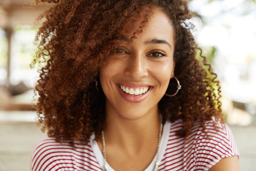

In [9]:
download_url(search_images('persona feliz', max_images=1)[0], 'persona_feliz.jpg', show_progress=False)

### Define las categorías del dataset

In [10]:
searches = 'persona_feliz','persona_enojada'
path = Path('feliz_o_enojado')

### Descarga imágenes para cada categoría y las almacena en carpetas separadas

In [ ]:
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

### Verifica si hay imágenes corruptas y las elimina

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

39

### Crea un DataBlock para el entrenamiento del modelo

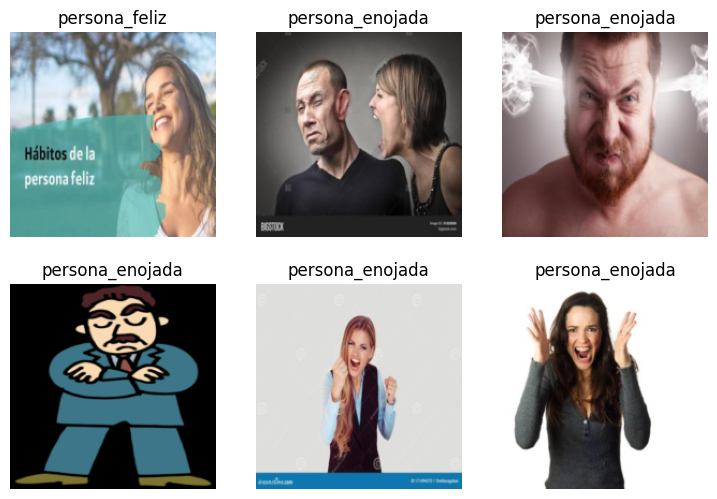

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

### Muestra algunas imágenes del dataset

In [ ]:
dls.show_batch(max_n=6)

### Carga un modelo de visión con ResNet50 y entrena con el dataset
### El modelo usado es ResNet50, pero con ResNet18 pueden haber buenos resultados
### La cantidad de epochs elegida es 5, pero con 3 da resultados también

In [44]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.923923,0.652676,0.164179,01:24


epoch,train_loss,valid_loss,error_rate,time
0,0.585495,0.601650,0.164179,02:02
1,0.391106,0.617911,0.119403,01:59
2,0.278769,0.742405,0.164179,02:02
3,0.214935,0.749625,0.149254,01:58
4,0.167978,0.724458,0.164179,01:57


### Realiza una predicción sobre una imagen de prueba


In [52]:
is_enojado,_,probs = learn.predict(PILImage.create('/kaggle/input/foto-emma/Captura de pantalla 2025-03-09 014952.png'))

Esto es: persona_feliz.
Probabilidad de que es una persona enojada: 0.0014


### Muestra el resultado de la predicción

In [ ]:
print(f"Esto es una: {is_enojado}.")
print(f"Probabilidad de que es una persona enojada: {probs[0]:.4f}")